<a href="https://colab.research.google.com/github/vinay10949/AnalyticsAndML/blob/master/1_4End_Distribution_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## End of distribution imputation

#### How do we select the value at the end?

- If the variable is normally distributed, we can use the mean plus or minus 3 times the standard deviation
- If the variable is skewed, we can use the IQR proximity rule
- We can also select the min / max value and multiply it by a certain amount of times, like 2 or 3.


### Which variables can I impute with an arbitrary value?

This method is suitable for numerical variables.

### Assumptions

- MNAR - values are not missing at random

If the value is not missing at random, we don't want to replace it for the mean / median and therefore make that observation look like the majority of our observations. Instead, we want to flag that observation as different, and therefore we assign a value that is at the tail of the distribution, where observations are rarely represented in the population.


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)
- Captures the importance of "missingess" if there is one

### Disadvantages

- Distortion of the original variable distribution
- Distortion of the original variance
- Distortion of the covariance with the remaining variables of the dataset
- This technique may mask true outliers in the distribution


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# to split the datasets
from sklearn.model_selection import train_test_split

In [2]:
# load the Titanic Dataset with a few variables for demonstration

data = pd.read_csv('titanic_train.csv', usecols=['Age', 'Fare', 'Survived'])
data.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [3]:
# let's look at the percentage of NA

data.isnull().mean()

Survived    0.000000
Age         0.198653
Fare        0.000000
dtype: float64

### Imputation important

Imputation has to be done over the training set, and then propagated to the test set. For this imputation technique, this means that when selecting the value with which we will replace the NA, we need to do so only by looking at the distribution of the variables in the training set. Then we use the selected value to replace NA both in the train and test set.

In [4]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Age', 'Fare']],  # predictors
    data['Survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((623, 2), (268, 2))

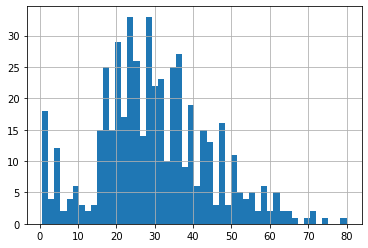

In [6]:
# let's have a look at the distribution of Ages
X_train.Age.hist(bins=50)

In [0]:
# let's make a function to fill missing values with an extreme value:
# the variable takes the dataframe, the variable, and the value to replace na

# and returns the variable with the filled na

def impute_na(df, variable, value):

    return df[variable].fillna(value)

In [8]:
# far end of the distribution:

# Because Age looks approximately Gaussian, I use the
# mean and std to calculate the replacement value

X_train.Age.mean() + 3 * X_train.Age.std()

73.43632005918366

In [12]:
# replace NA with the value calculated above

X_train['Age_imputed'] = impute_na(X_train, 'Age',
                                   X_train.Age.mean() + 3 * X_train.Age.std())

X_train.head(15)

,Age,Fare,Age_imputed
857,51.0,26.5500,51.00000
52,49.0,76.7292,49.00000
386,1.0,46.9000,1.00000
124,54.0,77.2875,54.00000
578,NaN,14.4583,73.43632
549,8.0,36.7500,8.00000
118,24.0,247.5208,24.00000
12,20.0,8.0500,20.00000
157,30.0,8.0500,30.00000
127,24.0,7.1417,24.00000


Look at the rows with missing data (NaN) in Age, and see how in the new variable they were replaced by 73.436.

In [13]:
# we can see a change in the variance after end of tail imputation
# this is expected, because the percentage of missing data is quite
# high in Age ~20%

print('Original variable variance: ', X_train['Age'].var())
print('Variance after 99 imputation: ', X_train['Age_imputed'].var())

Original variable variance:  210.45286924636747
Variance after 99 imputation:  466.4111899213168


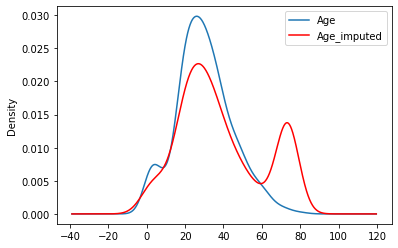

In [14]:
# we can see that the distribution has changed 
# with now more values accumulating towards the tail

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['Age'].plot(kind='kde', ax=ax)

# imputed variable
X_train['Age_imputed'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

As mentioned above, similarly to arbitrary value imputation, end of tail imputation distorts the original distribution of the variable Age. The transformed variable shows more values around selected tail value.

**Is this important?**

It depends on the machine learning model you want to build. Linear models assume that the variables are normally distributed. End of tail imputation may distort the original normal distribution if the % of missing data is high. Therefore the final imputed variable will no longer be normally distributed, which in turn may affect the linear model performance.

On the other hand, this technique works quite well with tree based algorithms.

In [16]:
# we also said end of tail imputation may affect the relationship 
# with the other variables in the dataset, let's have a look

X_train[['Fare', 'Age', 'Age_imputed']].cov()

,Fare,Age,Age_imputed
Fare,2328.801583,78.468894,-7.185565
Age,78.468894,210.452869,210.452869
Age_imputed,-7.185565,210.452869,466.411190


We see indeed that the covariance between Age and Fare is changed after the arbitrary value imputation.

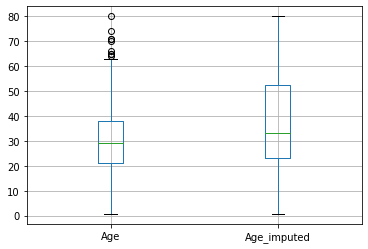

In [17]:
# Finally, I mentioned that end tail imputation may
# affect the perception of outliers

# Let's find out using a boxplot
X_train[['Age', 'Age_imputed']].boxplot()

Masks the outliers!!

## House Prices Dataset

Let's repeat the exercise in the House Prices dataset. In this dataset, there are variables with a lot or few missing data. Therefore we can compare the effect of end tail imputation in both scenarios.

In [0]:
# we are going to use only the following variables,
# 3 of which contain NA

cols_to_use = [
    'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF',
    'BsmtUnfSF', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice'
]

In [20]:
# let's load the House Prices dataset

data = pd.read_csv('houseprice_train.csv', usecols=cols_to_use)
print(data.shape)
data.head()

(1460, 10)


,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice
0,65.0,7,196.0,150,856,856,1710,2003.0,0,208500
1,80.0,6,0.0,284,1262,1262,1262,1976.0,298,181500
2,68.0,7,162.0,434,920,920,1786,2001.0,0,223500
3,60.0,7,0.0,540,756,961,1717,1998.0,0,140000
4,84.0,8,350.0,490,1145,1145,2198,2000.0,192,250000


In [21]:
# in the next list comprehension, I loop over all the columns 
# of the dataset and select those that contain missing data

[var for var in data.columns if data[var].isnull().sum()>0]

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [22]:
# find the percentage of missing data within those variables
# same code as we learnt in section 3 on variable characteristics

data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

In [23]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 10), (438, 10))

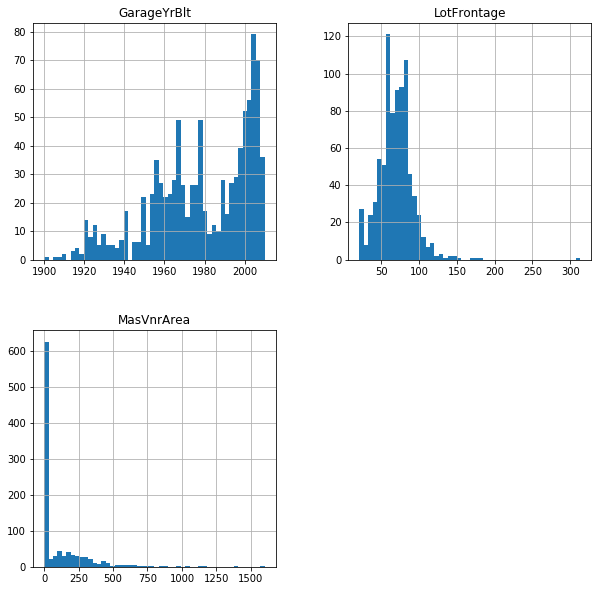

In [24]:
# let's plot the distributions of the variables
# we learnt this code in section 3 on variable characteristics

X_train[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].hist(bins=50, figsize=(10,10))
plt.show()

In [25]:
# the variables are not normally distributed

# let's impute the NA using the IQR proximity rule, which we learnt
# in the lecture on outliers in section 3

# calulate the IQR
IQR = X_train['LotFrontage'].quantile(0.75) - X_train['LotFrontage'].quantile(
    0.25)

# calculate the upper boundary
extreme_value = X_train['LotFrontage'].quantile(0.75) + 3 * IQR

extreme_value

146.0

In [26]:
# let's impute the NA with the extreme value

X_train.loc[:,'LotFrontage_imputed'] = impute_na(X_train, 'LotFrontage', extreme_value)
X_test.loc[:,'LotFrontage_imputed'] = impute_na(X_test, 'LotFrontage', extreme_value)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [27]:
# let's do the same for MasVnrArea

# calculate the IQR
IQR = X_train['MasVnrArea'].quantile(0.75) - X_train['MasVnrArea'].quantile(
    0.25)

# calculate the upper boundary
extreme_value = X_train['MasVnrArea'].quantile(0.75) + 3 * IQR

extreme_value

680.0

In [34]:
# let's impute the NA with the extreme value

X_train.loc[:,'MasVnrArea_imputed'] = impute_na(X_train, 'MasVnrArea', extreme_value)
X_test.loc[:,'MasVnrArea_imputed'] = impute_na(X_test, 'MasVnrArea', extreme_value)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


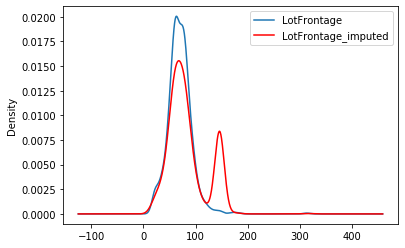

In [30]:
# let's evaluate the effect of end tail imputation on the distribution

# we can see that the distribution has changed for LotFrontAge
# with now more values accumulating towards the extreme value

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['LotFrontage'].plot(kind='kde', ax=ax)

# imputed variable
X_train['LotFrontage_imputed'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

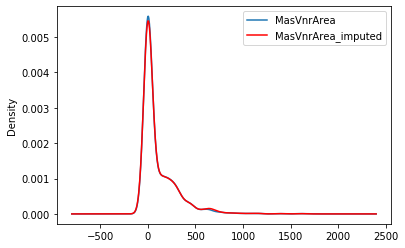

In [36]:
# let's evaluate the effect of arbitrary imputation on the distribution

# MasVnrArea had only few outliers, so the change in the distribution is
# not so dramatic. Less than when using an arbitrary value of 2999 as
# we did in the previous notebook

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['MasVnrArea'].plot(kind='kde', ax=ax)

# imputed variable
X_train['MasVnrArea_imputed'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

From the above plots we can see that the distribution of LotFrontAge is changed quite dramatically, but not so much the distribution of MasVnrArea. This is because the % of missing values in the second variable is quite small.

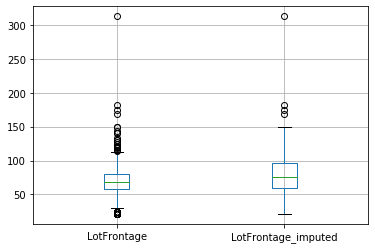

In [32]:
# we see that there are a fewer outliers as well after the imputation

X_train[['LotFrontage', 'LotFrontage_imputed']].boxplot()

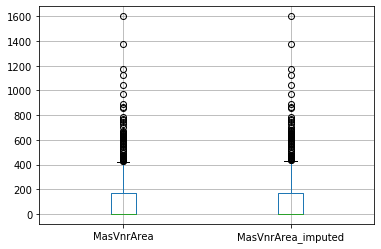

In [37]:
# however, the outliers are not so affected for MasVnrArea

X_train[['MasVnrArea', 'MasVnrArea_imputed']].boxplot()

In [39]:
# similarly we can explore the effect of the imputation technique on 
# the variance

# we can see a change in the variance after imputation for LotFrontAge
# this is expected, because the percentage of missing data is quite
# high ~20%

print('Original Variance: ', X_train['LotFrontage'].var())
print('Variance after imputation: ', X_train['LotFrontage_imputed'].var())

Original Variance:  532.5872021885676
Variance after imputation:  1313.0936747097685


In [38]:
# the same for MasnVnrArea is not so big
# Note particularly, that this effect is smaller than the one we observed
# when imputing by 2999 in the previous notebook!!!

print('Original Variance: ', X_train['MasVnrArea'].var())
print('Variance after imputation: ', X_train['MasVnrArea_imputed'].var())

Original Variance:  32983.538710039466
Variance after imputation:  34441.33126074531


In [40]:
# finally, let's explore the covariance:
# take your time to compare the values in the table below.

X_train.cov()

,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice,LotFrontage_imputed,MasVnrArea_imputed
LotFrontage,532.587202,6.587119,6.805603e+02,9.496573e+02,2.908856e+03,3.379794e+03,3.919952e+03,30.611717,1.347414e+02,6.689645e+05,532.587202,6.934872e+02
OverallQual,6.587119,1.843859,1.014970e+02,1.746147e+02,2.886241e+02,2.242973e+02,4.091242e+02,17.902809,3.168557e+01,8.320132e+04,3.425501,1.035991e+02
MasVnrArea,680.560330,101.496976,3.298354e+04,7.540788e+03,2.478877e+04,2.086595e+04,3.520785e+04,1203.583792,3.208924e+03,6.836439e+06,639.100679,3.298354e+04
BsmtUnfSF,949.657293,174.614725,7.540788e+03,1.875241e+05,7.513307e+04,4.987449e+04,5.203392e+04,1823.065167,-1.833201e+03,6.833028e+06,-850.739199,7.680598e+03
TotalBsmtSF,2908.855504,288.624075,2.478877e+04,7.513307e+04,1.682931e+05,1.212079e+05,8.615192e+04,3173.042442,1.227966e+04,2.003928e+07,2308.792907,2.473980e+04
1stFlrSF,3379.793504,224.297266,2.086595e+04,4.987449e+04,1.212079e+05,1.398656e+05,1.044401e+05,2009.195552,1.109406e+04,1.783631e+07,3142.724647,2.055453e+04
GrLivArea,3919.951834,409.124216,3.520785e+04,5.203392e+04,8.615192e+04,1.044401e+05,2.681277e+05,2738.982988,1.558395e+04,2.934477e+07,3723.250100,3.541558e+04
GarageYrBlt,30.611717,17.902809,1.203584e+03,1.823065e+03,3.173042e+03,2.009196e+03,2.738983e+03,624.305948,6.658911e+02,9.309355e+05,26.484608,1.274750e+03
WoodDeckSF,134.741376,31.685571,3.208924e+03,-1.833201e+03,1.227966e+04,1.109406e+04,1.558395e+04,665.891118,1.648582e+04,3.029981e+06,542.437312,3.088048e+03
SalePrice,668964.454191,83201.317781,6.836439e+06,6.833028e+06,2.003928e+07,1.783631e+07,2.934477e+07,930935.489321,3.029981e+06,6.105731e+09,578446.035624,6.872641e+06
